# WeatherML

## Setup Notebook

### Import Libraries

In [1]:
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

### Set Constants

In [2]:
COLOR_MAPPING = {
    'none': 'red',
    'jacket-short': 'orange',
    'jacket-long': 'green',
    'coat': 'blue'
}

RANDOM_STATE = 17

MONTHS = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']

## Data Processing

In [3]:
df = pd.read_csv('data/weather_data.csv')
print('# Records:', df.shape[0])
print('# Features:', df.shape[1])
df.head()

# Records: 630
# Features: 9


,Date,Time,Temp (°F),Feels Like (°F),Humidity (%),UV,Wind (mph),Gusts (mph),Outer Clothing
0,07/11/2023,13:55,80,80,44,9,4,NaN,none
1,07/12/2023,12:44,83,83,45,9,4,NaN,none
2,07/13/2023,20:15,75,78,79,0,4,NaN,none
3,07/17/2023,17:38,82,83,49,3,5,NaN,none
4,07/22/2023,18:03,75,76,58,2,4,NaN,none


### Remove Label Units

In [4]:
label_map = {
    'Temp (°F)': 'Temp',
    'Feels Like (°F)': 'Feels Like',
    'Humidity (%)': 'Humidity',
    'Wind (mph)': 'Wind',
    'Gusts (mph)': 'Gusts',
}
df.rename(columns=label_map, inplace=True)

### Date Type Cleaning

In [5]:
# convert humidity to decimal percents
df['Humidity'] = df['Humidity'] / 100

# convert dates to datetime
df['Date'] = pd.to_datetime(df['Date'])

### Add Season Data

In [6]:
def get_season(date: datetime) -> str:
    if date.month in [12, 1, 2]:
        return 'Winter'
    elif date.month in [3, 4, 5]:
        return 'Spring'
    elif date.month in [6, 7, 8]:
        return 'Summer'
    elif date.month in [9, 10, 11]:
        return 'Fall'

df['Season'] = [get_season(date_str) for date_str in df['Date']]

### Interpolate Gusts Data

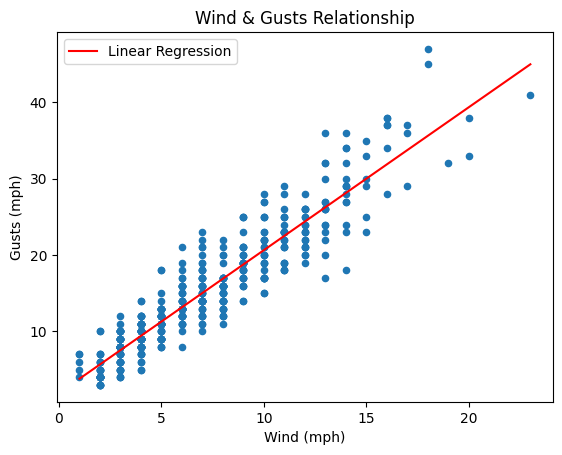

In [7]:
df_gust = df.copy()

# prep data
non_missing = df_gust.dropna(subset=['Gusts'])
missing = df_gust[df_gust['Gusts'].isnull()]

X_train = non_missing[['Wind']].values
y_train = non_missing['Gusts'].values

# train model
model = LinearRegression()
model.fit(X_train, y_train)

# plot data points & regression line
m, b = model.coef_[0], model.intercept_
x_line = np.linspace(df_gust['Wind'].values.min(), df_gust['Wind'].values.max())
y_line = m * x_line + b
df_gust.dropna().plot.scatter('Wind', 'Gusts');
plt.plot(x_line, y_line, color='red', label='Linear Regression')
plt.title('Wind & Gusts Relationship')
plt.xlabel('Wind (mph)')
plt.ylabel('Gusts (mph)')
plt.legend();

In [8]:
X_missing = missing[['Wind']].values
df.loc[df['Gusts'].isnull(), 'Gusts'] = model.predict(X_missing).round()
df.head()

,Date,Time,Temp,Feels Like,Humidity,UV,Wind,Gusts,Outer Clothing,Season
0,2023-07-11,13:55,80,80,0.44,9,4,9.0,none,Summer
1,2023-07-12,12:44,83,83,0.45,9,4,9.0,none,Summer
2,2023-07-13,20:15,75,78,0.79,0,4,9.0,none,Summer
3,2023-07-17,17:38,82,83,0.49,3,5,11.0,none,Summer
4,2023-07-22,18:03,75,76,0.58,2,4,9.0,none,Summer


## Data Analysis & Visualizations

### Target Class Distribution

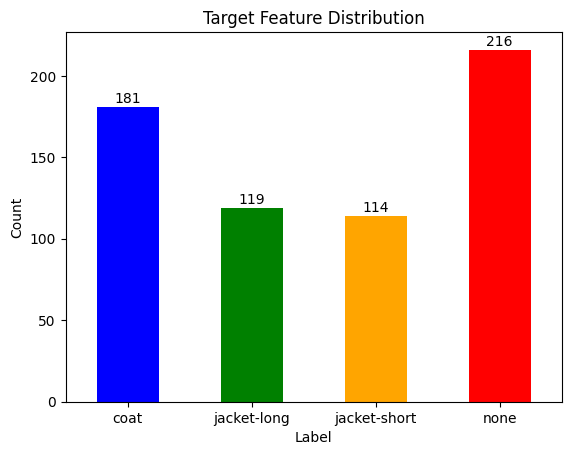

In [9]:
label_distr = df['Outer Clothing'].value_counts().sort_index()
colors = [COLOR_MAPPING[label] for label in label_distr.index]

ax = label_distr.plot(kind='bar', color=colors)
for i, count in enumerate(label_distr):
    ax.text(i, count + 5, f'{label_distr.iloc[i]}', ha='center', va='center')

plt.title('Target Feature Distribution')
plt.xticks(rotation=0)
plt.xlabel('Label')
plt.ylabel('Count');

### Date Distribution

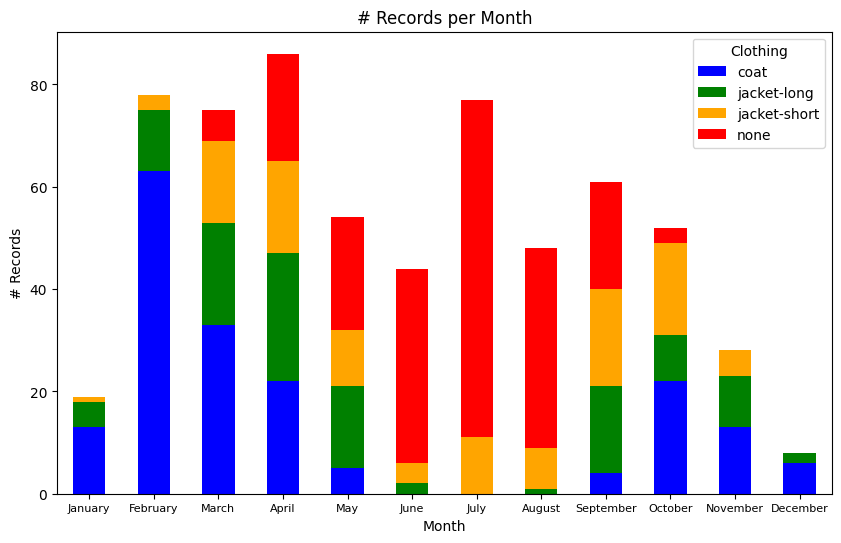

In [10]:
df_date = df[['Date', 'Outer Clothing']].copy()
df_date['Month'] = df_date['Date'].dt.month_name()
month_group = df_date.groupby(['Month', 'Outer Clothing']).size().reset_index(name='Count')
pivot = month_group.pivot(index='Month', columns='Outer Clothing', values='Count')
pivot = pivot.reindex(MONTHS)

ax = pivot.plot(kind='bar', stacked=True, figsize=(10, 6), color=['blue', 'green', 'orange', 'red'])
plt.title('# Records per Month')
plt.xlabel('Month')
plt.ylabel('# Records')
plt.xticks(rotation=0, size=8)
plt.legend(title='Clothing');

### Boxplots

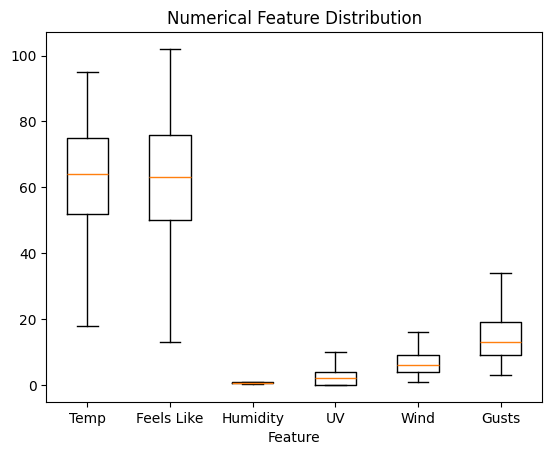

In [11]:
numeric_columns = df.select_dtypes(include=['number'])
plt.boxplot(numeric_columns, labels=numeric_columns.columns, showfliers=False)
plt.title('Numerical Feature Distribution')
plt.xlabel('Feature');

### Correlation Matrix

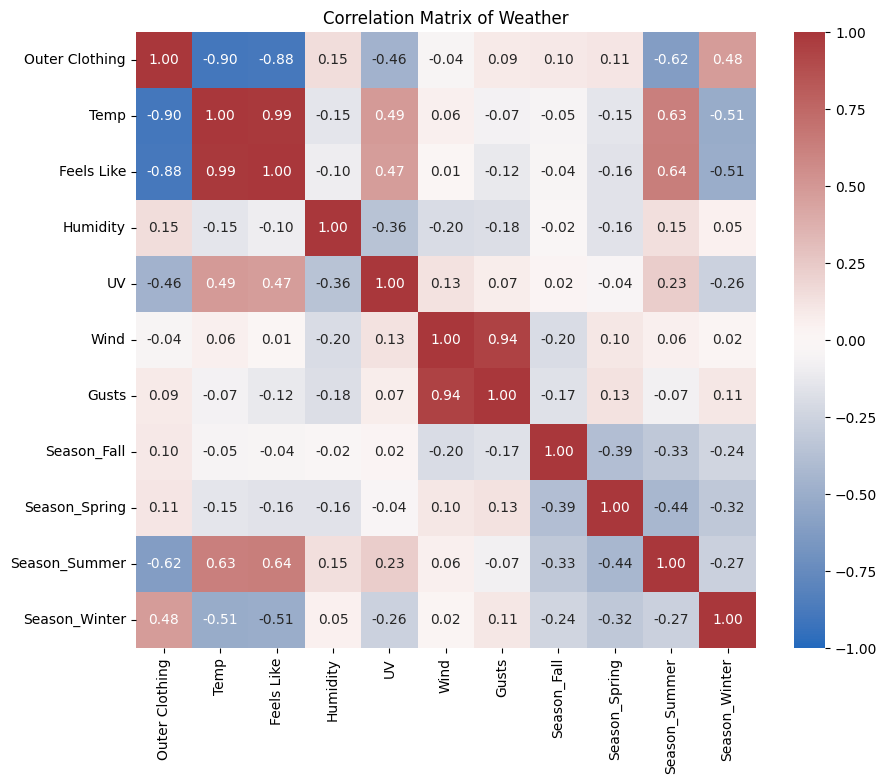

In [12]:
df_corr = df.copy()

# filter features
df_corr.replace({'none': 1, 'jacket-short': 2, 'jacket-long': 3, 'coat': 4}, inplace=True)
df_corr.drop(columns=['Date', 'Time'], inplace=True)
df_corr = pd.get_dummies(df_corr, columns=['Season'])
columns = ['Outer Clothing'] + [col for col in df_corr.columns if col != 'Outer Clothing']
df_corr = df_corr[columns]

# normalize numerical data
scaler = StandardScaler()
numeric_columns = df_corr.select_dtypes(include=['number']).columns
df_corr[numeric_columns] = scaler.fit_transform(df_corr[numeric_columns])

# get correlation matrix
corr_matrix = df_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    vmin=-1,
    vmax=1,
    fmt='.2f',
    annot=True,
    cmap='vlag'
)
plt.title("Correlation Matrix of Weather");

### Principal Component Analysis (PCA)

First we need to preprocess the data. We will be recycling the results from our
correlation matrix since the steps are similar. We just need to re-adjust the
target feature.

In [13]:
df_pca = df_corr.copy()
df_pca['Outer Clothing'] = df['Outer Clothing']
df_pca['Outer Clothing'].replace({'none': '1', 'jacket-short': '2', 'jacket-long': '3', 'coat': '4'}, inplace=True)

Next, we will start off with reducing features to just 2, which we can then plot
on a 2D scatter plot.

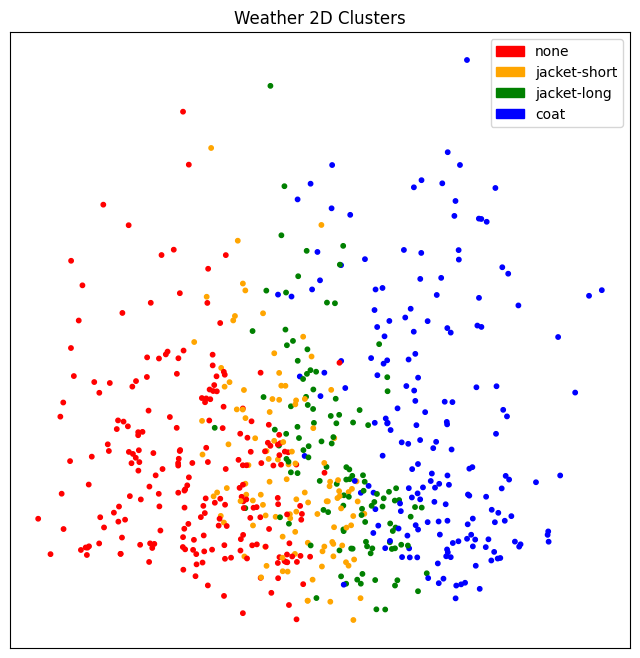

In [14]:
# reduce to 2 components
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(df_pca.drop(columns=['Outer Clothing']))

# custom color map
custom_cmap = mcolors.ListedColormap(COLOR_MAPPING.values())

# 2D scatter plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=df_pca['Outer Clothing'].astype(int),
    s=10,
    cmap=custom_cmap,
)
ax.set_xticks([])
ax.set_yticks([])

# Add legend
handles = [mpatches.Patch(color=color, label=label) for label, color in COLOR_MAPPING.items()]
plt.legend(handles=handles, loc='best')
plt.title('Weather 2D Clusters');

Finally, we can expand on our code to plot on a 3D scatter plot instead.

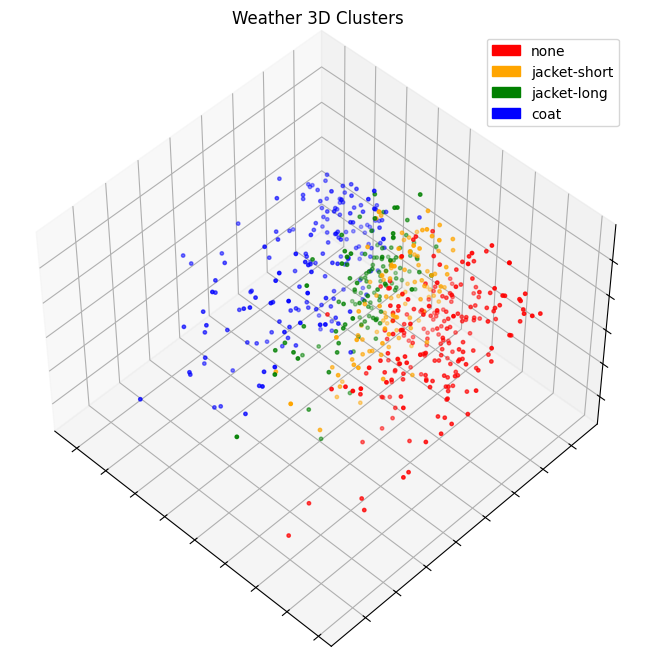

In [15]:
# reduce to 3 components
pca_3d = PCA(n_components=3)
X_3d = pca_3d.fit_transform(df_pca.drop(columns=['Outer Clothing']))

# custom color map
custom_cmap = mcolors.ListedColormap(COLOR_MAPPING.values())

# 3D scatter plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d', elev=48, azim=134)
ax.scatter(
    X_3d[:, 0],
    X_3d[:, 1],
    X_3d[:, 2],
    c=df_pca['Outer Clothing'].astype(int),
    s=6,
    cmap=custom_cmap
)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

# legend & title
handles = [mpatches.Patch(color=color, label=label) for label,color in COLOR_MAPPING.items()]
plt.legend(handles=handles, loc='best')
plt.title('Weather 3D Clusters');

## Machine Learning Models

### ML Libraries

In [16]:
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

### Preprocess

In [17]:
df_ml = df.copy()
df_ml.head()

,Date,Time,Temp,Feels Like,Humidity,UV,Wind,Gusts,Outer Clothing,Season
0,2023-07-11,13:55,80,80,0.44,9,4,9.0,none,Summer
1,2023-07-12,12:44,83,83,0.45,9,4,9.0,none,Summer
2,2023-07-13,20:15,75,78,0.79,0,4,9.0,none,Summer
3,2023-07-17,17:38,82,83,0.49,3,5,11.0,none,Summer
4,2023-07-22,18:03,75,76,0.58,2,4,9.0,none,Summer


In [18]:
# drop Date and Time
df_ml.drop(columns=['Date', 'Time'], inplace=True)

# one-hot encode season
df_ml = pd.get_dummies(df_ml, columns=['Season'])

# split into X/y
X = df_ml.drop(columns=['Outer Clothing'])
y = df_ml['Outer Clothing']

# split off testing data
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)

# split rest into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=2/9, random_state=1234)

# normalize
numeric_columns = df_ml.select_dtypes(include=['number']).columns
scaler = StandardScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_val[numeric_columns] = scaler.transform(X_val[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

# print results
print('Train size:', X_train.shape[0])
print('Val size:', X_val.shape[0])
print('Test size:', X_test.shape[0])


Train size: 441
Val size: 126
Test size: 63


### Scoring Functions

In [19]:
def score_model(y_true: pd.Series, y_pred: np.ndarray, params: str) -> None:
    print(f'Params: {params}')
    print(f' - Accuracy:  {accuracy_score(y_true, y_pred)}')
    print(f' - Precision: {precision_score(y_true, y_pred, average="macro")}')
    print(f' - Recall:    {recall_score(y_true, y_pred, average="macro")}')
    print(f' - F1:        {f1_score(y_true, y_pred, average="macro")}')

def display_cm(y_true: pd.Series, y_pred: np.ndarray, params: str) -> None:
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['coat', 'jacket-long', 'jacket-short', 'none'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{params}')
    plt.show()

### Logistic Regression

In [20]:
lr_params = {
    'solver': ['saga', 'sag', 'newton-cg'],
    'penalty': [None, 'l2']
}

lr_model = LogisticRegression(
    random_state=RANDOM_STATE,
    multi_class='multinomial',
    class_weight='balanced',
    n_jobs=-2,
    max_iter=2000
)

lr_grid = GridSearchCV(lr_model, lr_params, cv=5, scoring=['accuracy', 'f1_macro'], refit='f1_macro')
lr_grid.fit(X_train, y_train)

print('Logistic Regression Best Params:', lr_grid.best_params_)
print('Logistic Regression Best Score:', lr_grid.best_score_)

Logistic Regression Best Params: {'penalty': 'l2', 'solver': 'saga'}
Logistic Regression Best Score: 0.7888389759584551


In [21]:
i = 0
lr_codes = []
lr_acc = []
lr_f1 = []
for param in lr_grid.cv_results_['params']:
    code = f'LR{i + 1}'
    lr_codes.append(code)
    acc = lr_grid.cv_results_['mean_test_accuracy'][i]
    lr_acc.append(acc)
    f1 = lr_grid.cv_results_['mean_test_f1_macro'][i]
    lr_f1.append(f1)
    print(f'{code}:', param)
    print(f' - Acc:', acc)
    print(f' - F1: ', f1)
    i += 1

LR1: {'penalty': None, 'solver': 'saga'}
 - Acc: 0.8027068437180797
 - F1:  0.7761479085867079
LR2: {'penalty': None, 'solver': 'sag'}
 - Acc: 0.8027068437180797
 - F1:  0.7761479085867079
LR3: {'penalty': None, 'solver': 'newton-cg'}
 - Acc: 0.8027068437180797
 - F1:  0.7761479085867079
LR4: {'penalty': 'l2', 'solver': 'saga'}
 - Acc: 0.8117977528089888
 - F1:  0.7888389759584551
LR5: {'penalty': 'l2', 'solver': 'sag'}
 - Acc: 0.8117977528089888
 - F1:  0.7888389759584551
LR6: {'penalty': 'l2', 'solver': 'newton-cg'}
 - Acc: 0.8117977528089888
 - F1:  0.7888389759584551


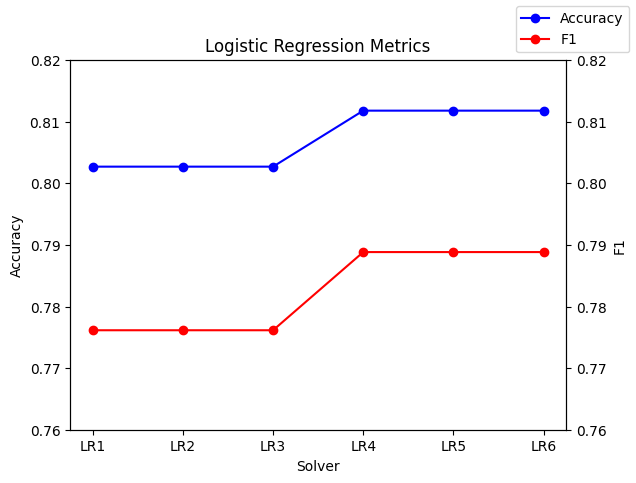

In [22]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Solver')
ax1.set_ylabel('Accuracy')
ax2 = ax1.twinx()
ax2.set_ylabel('F1')

ax1.plot(lr_codes, lr_acc, 'b-', label='Accuracy', marker='o')
ax1.set_ylim(0.76, 0.82)


ax2.plot(lr_codes, lr_f1, 'r-', label='F1', marker='o')
ax2.set_ylim(0.76, 0.82)

plt.title('Logistic Regression Metrics')
fig.legend(loc='upper right');

### Decision Tree

In [23]:
dt_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

dt_model = DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    class_weight='balanced'
)

dt_grid = GridSearchCV(dt_model, dt_params, cv=5, scoring=['accuracy', 'f1_macro'], refit='f1_macro')
dt_grid.fit(X_train, y_train)

print('DecisionTree Best Params:', dt_grid.best_params_)
print('DecisionTree Best Score:', dt_grid.best_score_)

DecisionTree Best Params: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 10}
DecisionTree Best Score: 0.7644059676758818


In [24]:
i = 0
dt_codes = []
dt_acc = []
dt_f1 = []
for param in dt_grid.cv_results_['params']:
    code = f'DT{i + 1}'
    dt_codes.append(code)
    acc = dt_grid.cv_results_['mean_test_accuracy'][i]
    dt_acc.append(acc)
    f1 = dt_grid.cv_results_['mean_test_f1_macro'][i]
    dt_f1.append(f1)
    print(f'{code}:', param)
    print(f' - Acc:', acc)
    print(f' - F1: ', f1)
    i += 1

DT1: {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1}
 - Acc: 0.7437180796731359
 - F1:  0.7060267987617758
DT2: {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 5}
 - Acc: 0.7686414708886619
 - F1:  0.7374757358587795
DT3: {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 10}
 - Acc: 0.7777068437180796
 - F1:  0.7489563235455645
DT4: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1}
 - Acc: 0.750638406537283
 - F1:  0.7179478233331823
DT5: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5}
 - Acc: 0.7186670071501531
 - F1:  0.6935673554551809
DT6: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10}
 - Acc: 0.7460418794688458
 - F1:  0.7220373685789713
DT7: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1}
 - Acc: 0.750638406537283
 - F1:  0.71794782

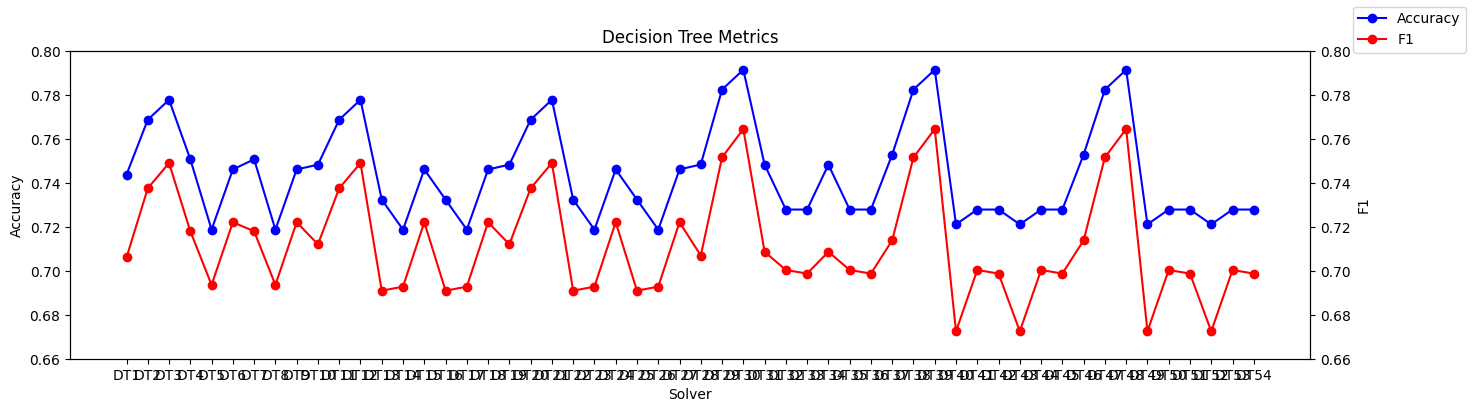

In [25]:
fig, ax1 = plt.subplots(figsize=(16,4))

ax1.plot(dt_codes, dt_acc, 'b-', label='Accuracy', marker='o')
ax1.set_xlabel('Solver')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0.66, 0.80)

ax2 = ax1.twinx()
ax2.plot(dt_codes, dt_f1, 'r-', label='F1', marker='o')
ax2.set_ylabel('F1')
ax2.set_ylim(0.66, 0.80)

plt.title('Decision Tree Metrics')
fig.legend(loc='upper right');

### KNN

In [26]:
knn_params = {
    'n_neighbors': np.arange(1, 26, 2),
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3, 4, 5],
    'algorithm': ['ball_tree', 'kd_tree', 'brute']
}

knn_model = KNeighborsClassifier(
    n_jobs=-2
)

knn_grid = GridSearchCV(knn_model, knn_params, cv=5, scoring=['accuracy', 'f1_macro'], refit='f1_macro')
knn_grid.fit(X_train, y_train)

print('KNN Best Params:', knn_grid.best_params_)
print('KNN Best Score:', knn_grid.best_score_)

KNN Best Params: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
KNN Best Score: 0.7243643318978752


In [27]:
i = 0
knn_codes = []
knn_acc = []
knn_f1 = []
for param in knn_grid.cv_results_['params']:
    code = f'KNN{i + 1}'
    knn_codes.append(code)
    acc = knn_grid.cv_results_['mean_test_accuracy'][i]
    knn_acc.append(acc)
    f1 = knn_grid.cv_results_['mean_test_f1_macro'][i]
    knn_f1.append(f1)
    print(f'{code}:', param)
    print(f' - Acc:', acc)
    print(f' - F1: ', f1)
    i += 1

KNN1: {'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
 - Acc: 0.7278600612870276
 - F1:  0.6880428979262035
KNN2: {'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}
 - Acc: 0.7278600612870276
 - F1:  0.6880428979262035
KNN3: {'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
 - Acc: 0.7323544433094995
 - F1:  0.6923255819517934
KNN4: {'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 2, 'weights': 'distance'}
 - Acc: 0.7323544433094995
 - F1:  0.6923255819517934
KNN5: {'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 3, 'weights': 'uniform'}
 - Acc: 0.7255362614913177
 - F1:  0.6859301529155445
KNN6: {'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 3, 'weights': 'distance'}
 - Acc: 0.7255362614913177
 - F1:  0.6859301529155445
KNN7: {'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 4, 'weights': 'uniform'}
 - Acc: 0.7209652706843718
 - F1:  0.6825199307127588
KNN8: {'algorithm': 'ball_tree', 'n_neighbors': 1, '

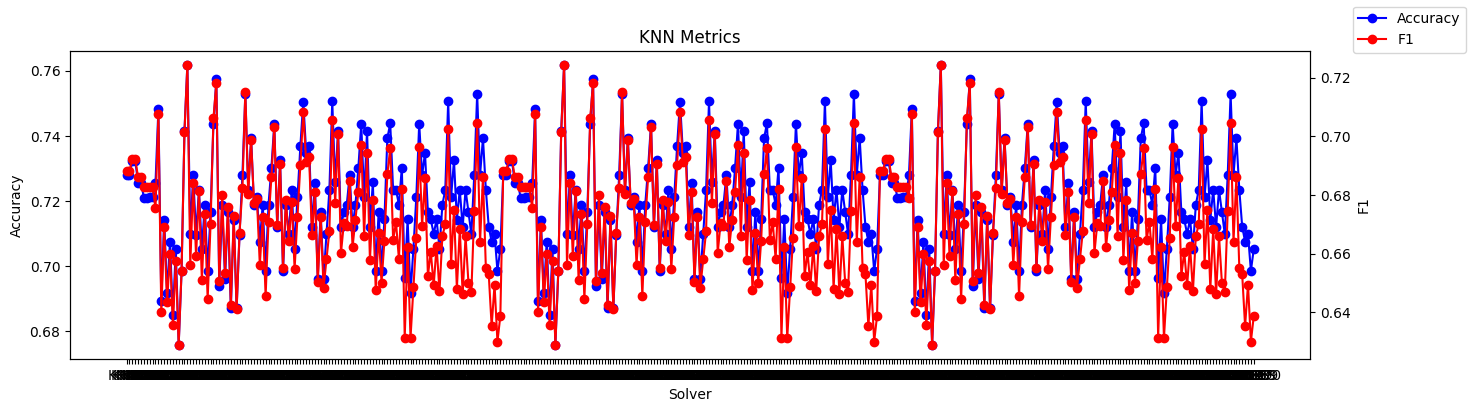

In [28]:
fig, ax1 = plt.subplots(figsize=(16,4))

ax1.plot(knn_codes, knn_acc, 'b-', label='Accuracy', marker='o')
ax1.set_xlabel('Solver')
ax1.set_ylabel('Accuracy')
# ax1.set_ylim(0.76, 0.82)

ax2 = ax1.twinx()
ax2.plot(knn_codes, knn_f1, 'r-', label='F1', marker='o')
ax2.set_ylabel('F1')
# ax2.set_ylim(0.76, 0.82)

plt.title('KNN Metrics')
fig.legend(loc='upper right');

### Neural Network

In [29]:
mlp_sizes = [
    (10,), 
    (20,), 
    (50,), 
    (10, 10), 
    (20, 20), 
    (50, 20), 
    (10, 10, 10), 
    (20, 20, 20)
]

mlp_size_acc = []
mlp_size_f1 = []

for size in mlp_sizes:
    mlp = MLPClassifier(
        random_state=RANDOM_STATE,
        max_iter=2000,
        hidden_layer_sizes=size
    )
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_val)
    score_model(y_val, y_pred, f'Neural Network (Size={size})')
    mlp_size_acc.append(accuracy_score(y_val, y_pred))
    mlp_size_f1.append(f1_score(y_val, y_pred, average='macro'))

Params: Neural Network (Size=(10,))
 - Accuracy:  0.8095238095238095
 - Precision: 0.7568266171792153
 - Recall:    0.7400830950009105
 - F1:        0.7413800291849072
Params: Neural Network (Size=(20,))
 - Accuracy:  0.8253968253968254
 - Precision: 0.7775974025974026
 - Recall:    0.7678608727786882
 - F1:        0.7645976011939868


c:\Users\Me\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Params: Neural Network (Size=(50,))
 - Accuracy:  0.8174603174603174
 - Precision: 0.7785855743172816
 - Recall:    0.7829494574590015
 - F1:        0.772649015260206
Params: Neural Network (Size=(10, 10))
 - Accuracy:  0.7857142857142857
 - Precision: 0.7261672151378034
 - Recall:    0.7278290594170763
 - F1:        0.7193181818181819
Params: Neural Network (Size=(20, 20))
 - Accuracy:  0.7936507936507936
 - Precision: 0.749949124949125
 - Recall:    0.7520934423771115
 - F1:        0.7425300939055902
Params: Neural Network (Size=(50, 20))
 - Accuracy:  0.7777777777777778
 - Precision: 0.7388012115415272
 - Recall:    0.732938478100196
 - F1:        0.7265901482544237
Params: Neural Network (Size=(10, 10, 10))
 - Accuracy:  0.7698412698412699
 - Precision: 0.7093645484949833
 - Recall:    0.7030706053107961
 - F1:        0.6961988304093567
Params: Neural Network (Size=(20, 20, 20))
 - Accuracy:  0.8412698412698413
 - Precision: 0.8015723731353006
 - Recall:    0.8004106547982476
 - F1

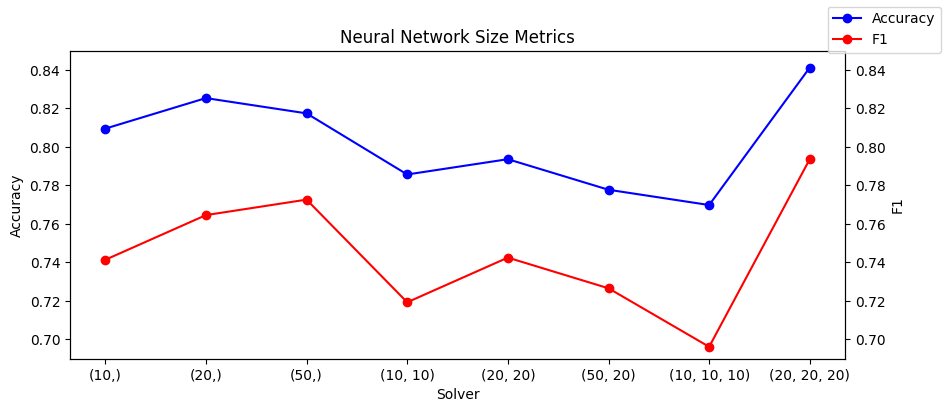

In [35]:
mlp_sizes = [str(size) for size in mlp_sizes]

fig, ax1 = plt.subplots(figsize=(10,4))

ax1.plot(mlp_sizes, mlp_size_acc, 'b-', label='Accuracy', marker='o')
ax1.set_xlabel('Solver')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0.69, 0.85)

ax2 = ax1.twinx()
ax2.plot(mlp_sizes, mlp_size_f1, 'r-', label='F1', marker='o')
ax2.set_ylabel('F1')
ax2.set_ylim(0.69, 0.85)

plt.title('Neural Network Size Metrics')
fig.legend(loc='upper right');

In [31]:
mlp_params = {
    'hidden_layer_sizes' : [
        (20, 20, 20)
    ],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'adam'],
    'alpha': [0.0001, 0.001, 0.01]
}

mlp_model = MLPClassifier(
    random_state=RANDOM_STATE,
    max_iter=2000
)

mlp_grid = GridSearchCV(mlp_model, mlp_params, cv=5, scoring=['accuracy', 'f1_macro'], refit='f1_macro')
mlp_grid.fit(X_train, y_train)

print('NeuralNetwork Best Params:', mlp_grid.best_params_)
print('NeuralNetwork Best Score:', mlp_grid.best_score_)

NeuralNetwork Best Params: {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (20, 20, 20), 'solver': 'adam'}
NeuralNetwork Best Score: 0.8050967356588445


In [32]:
i = 0
mlp_codes = []
mlp_acc = []
mlp_f1 = []
for param in mlp_grid.cv_results_['params']:
    code = f'NN{i + 1}'
    mlp_codes.append(code)
    acc = mlp_grid.cv_results_['mean_test_accuracy'][i]
    mlp_acc.append(acc)
    f1 = mlp_grid.cv_results_['mean_test_f1_macro'][i]
    mlp_f1.append(f1)
    print(f'{code}:', param)
    print(f' - Acc:', acc)
    print(f' - F1: ', f1)
    i += 1

NN1: {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (20, 20, 20), 'solver': 'lbfgs'}
 - Acc: 0.7345760980592442
 - F1:  0.6820720170097103
NN2: {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (20, 20, 20), 'solver': 'adam'}
 - Acc: 0.8322778345250257
 - F1:  0.8029500670367467
NN3: {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (20, 20, 20), 'solver': 'lbfgs'}
 - Acc: 0.7664708886618998
 - F1:  0.7313073822789878
NN4: {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (20, 20, 20), 'solver': 'adam'}
 - Acc: 0.8345505617977528
 - F1:  0.8050967356588445
NN5: {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (20, 20, 20), 'solver': 'lbfgs'}
 - Acc: 0.7414453524004087
 - F1:  0.7019240012401718
NN6: {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (20, 20, 20), 'solver': 'adam'}
 - Acc: 0.8322778345250257
 - F1:  0.8024436425023189
NN7: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_si

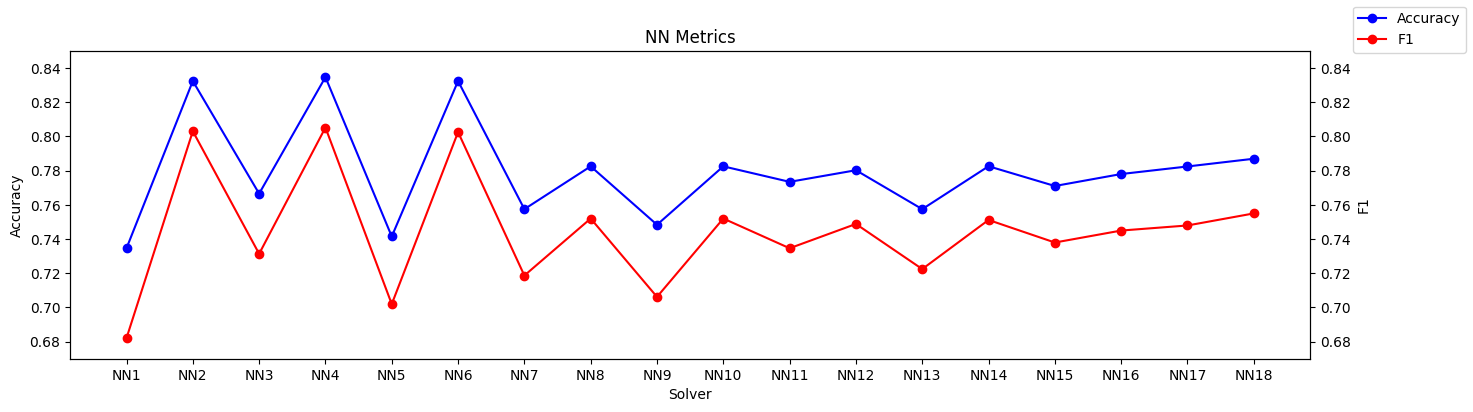

In [33]:
fig, ax1 = plt.subplots(figsize=(16,4))

ax1.plot(mlp_codes, mlp_acc, 'b-', label='Accuracy', marker='o')
ax1.set_xlabel('Solver')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0.67, 0.85)

ax2 = ax1.twinx()
ax2.plot(mlp_codes, mlp_f1, 'r-', label='F1', marker='o')
ax2.set_ylabel('F1')
ax2.set_ylim(0.67, 0.85)

plt.title('NN Metrics')
fig.legend(loc='upper right');